# Symmetry resolved spectra.
Plot the points in the spectrum resolved with some information on their quantum numbers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../python_data/')
from ed_result_wrapper import EDResult

data_dir = "../python_quantum_info/data/"

def _select_close(cond, df, atol=1e-8):
    """ Selects rows of df if they are close to all conditions in the 
        cond dictionary.
    
        Use with caution!
    
        Note:
         -  The numerical tolerance for closenes is toggled via atol. 
            The standard is 1e-8 (in fact, by numpy) but this could 
            lead to problems when comparing very small numbers.
            
    """
    m = sub.apply(lambda r: all([np.isclose(r[o], v, atol=atol) for o, v in cond.items()]), axis=1)
    return df[m]

In [27]:
data_222 = {
    'bosons' : {
        (0,0,0): EDResult({'L':[2,2,2], 'gauge_particles':'bosons','winding_sector':[0,0,0]}, data_dir)
    },
    
    'fermions' : {
        (0,0,0): EDResult({'L':[2,2,2], 'gauge_particles':'fermions','winding_sector':[0,0,0]}, data_dir),
        (0,0,1): EDResult({'L':[2,2,2], 'gauge_particles':'fermions','winding_sector':[0,0,1]}, data_dir)
    },
}

ED results for datafile '../python_quantum_info/data//results_bosons_wx_2-wy_2-wz_2_2x2x2.hdf5'
ED results for datafile '../python_quantum_info/data//results_fermions_wx_2-wy_2-wz_2_2x2x2.hdf5'
ED results for datafile '../python_quantum_info/data//results_fermions_wx_2-wy_2-wz_3_2x2x2.hdf5'


## 2x2x2 systems

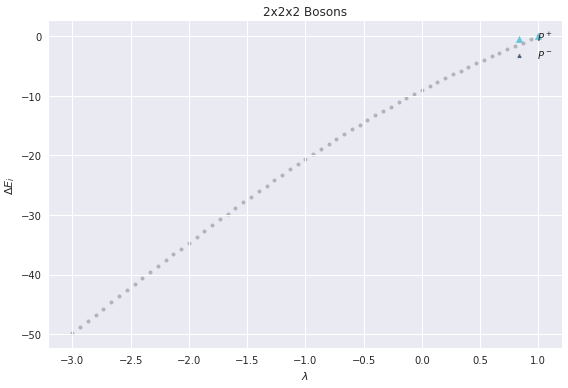

In [29]:
df = data_222['bosons'][(0,0,0)].get_eigenvalues()

# Select only the lowest states.
n_states = 25

dependency = 'lambda'
observable = 'spectrum'
with plt.style.context('seaborn'):
    fig, bx = plt.subplots()
#     fig.set_size_inches(12, 6)

    sub = df[
        (df['N']==0)
    ]


    # All points.
    bx.scatter(sub[dependency], sub[observable], marker='.', color='gray', alpha=0.5, zorder=0)

    # Highlight some.
    sets = [
        (
            {'parity': 1, 'unity': 1}, 
            {"color":"#68C5DB", 'marker':'^', 'label':'$P^+$', 's':45}
        ),        
        (
            {'parity': -1}, 
            {"color":"#4F5D75", 'marker':'2', 'label':'$P^-$', 's':20}
        )
    ]
    for cond, style in sets:
        red = _select_close(cond, sub, atol=1e-2)
        bx.scatter(red[dependency], red[observable], **style)

    # ---
       
    # ---
        
    bx.set_xlabel('$\\lambda$')
    bx.set_ylabel('$\\Delta E_i$')
#     bx.set_ylim(0, 5)

    bx.legend(loc='upper right')
    bx.set_title('2x2x2 Bosons')
    
    fig.tight_layout()
#     fig.savefig('parity_2x2x2.png')


In [30]:
sub

,lambda,L,gauge_particles,winding_sector,N,susceptibility,spectrum,unity,parity
0,-3.000000,"(2, 2, 2)",bosons,"(0, 0, 0)",0,0.0,-4.977355e+01,1.000000+0.000000j,0.760349+0.000000j
880,-2.933333,"(2, 2, 2)",bosons,"(0, 0, 0)",0,0.0,-4.874649e+01,1.000000+0.000000j,0.750864+0.000000j
1760,-2.866667,"(2, 2, 2)",bosons,"(0, 0, 0)",0,0.0,-4.772118e+01,1.000000+0.000000j,0.740852+0.000000j
2640,-2.800000,"(2, 2, 2)",bosons,"(0, 0, 0)",0,0.0,-4.669774e+01,1.000000+0.000000j,0.730278+0.000000j
3520,-2.733333,"(2, 2, 2)",bosons,"(0, 0, 0)",0,0.0,-4.567629e+01,1.000000+0.000000j,0.719106+0.000000j
...,...,...,...,...,...,...,...,...,...
49280,0.733333,"(2, 2, 2)",bosons,"(0, 0, 0)",0,0.0,-2.207962e+00,1.000000+0.000000j,-0.286626+0.000000j
50160,0.800000,"(2, 2, 2)",bosons,"(0, 0, 0)",0,0.0,-1.642443e+00,1.000000+0.000000j,-0.275227+0.000000j
51040,0.866667,"(2, 2, 2)",bosons,"(0, 0, 0)",0,0.0,-1.085772e+00,1.000000+0.000000j,-0.261002+0.000000j
51920,0.933333,"(2, 2, 2)",bosons,"(0, 0, 0)",0,0.0,-5.381793e-01,1.000000+0.000000j,-0.243507+0.000000j


ED results for datafile '/home/lukas/_TEMP_fqlm//results_fermions_all-ws_2x2x2.hdf5'


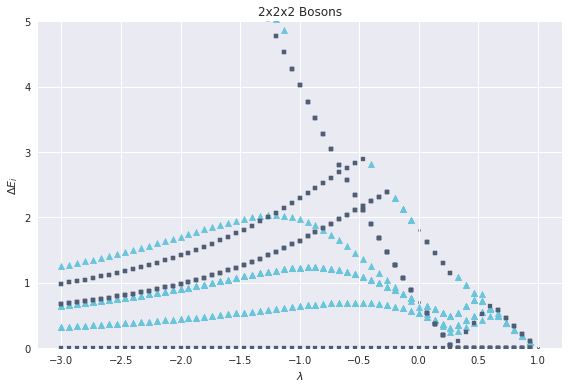

In [21]:
# Choose the dataset.
param = {
    'L' : [2,2,2],
    'gauge_particles' : 'fermions',
#     'ws' : 'wx_2-wy_2-wz_2'
#     'winding_sector' : [0,0,0]
}
res_000 = EDResult(param, data_dir)
res_000.compute_gap()
df = res_000.get_eigenvalues()

# Select only the lowest states.
n_states = 25




dependency = 'lambda'
observable = 'delta_e'
with plt.style.context('seaborn'):
    fig, bx = plt.subplots()
#     fig.set_size_inches(12, 6)
    
    sub = df[
        (df['N']<20)
    ]

    # All points.
    bx.scatter(sub[dependency], sub[observable], marker='.', color='gray', alpha=0.5, zorder=0, s=20)

#     Highlight some.
    sets = [
        (
            {'parity': 1, 'unity': 1}, 
            {"color":"#68C5DB", 'marker':'^', 'label':'$P^+$', 's':45}
        ),        
        (
            {'parity': -1}, 
            {"color":"#4F5D75", 'marker':'s', 'label':'$P^-$', 's':20}
        )
    ]
    for cond, style in sets:
        red = _select_close(cond, sub)
        bx.scatter(red[dependency], red[observable], **style)

    # ---
       
    # ---
        
    bx.set_xlabel('$\\lambda$')
    bx.set_ylabel('$\\Delta E_i$')
    bx.set_ylim(0, 5)

#     bx.legend(loc='upper left')
    bx.set_title('2x2x2 Bosons')
    
    fig.tight_layout()
#     fig.savefig('parity_2x2x2.png')

ED results for datafile '/home/lukas/_TEMP_fqlm//results_fermions_wx_2-wy_2-wz_2_2x2x2.hdf5'


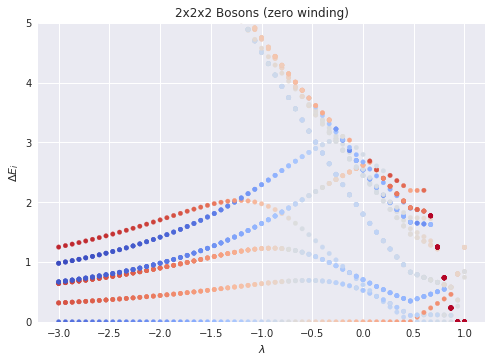

In [14]:
from matplotlib import cm


# Choose the dataset.
param = {
    'L' : [2,2,2],
    'gp' : 'fermions',
#     'ws' : 'wx_2-wy_2-wz_2'
    'ws' : [0,0,0]
}
res_000 = EDResult(param, data_dir)
res_000.compute_gap()
df = res_000.get_eigenvalues()

# Select only the lowest states.
n_states = 25
sub = df[df['N']<n_states]


dependency = 'lambda'
observable = 'delta_e'
with plt.style.context('seaborn'):
    fig, bx = plt.subplots()
#     fig.set_size_inches(12, 6)
    
    # All points.
    bx.scatter(
        sub[dependency], sub[observable], c=sub["parity"].values.real, cmap=cm.coolwarm,
        marker='o', s=20
    )
            
    # ---
        
    bx.set_xlabel('$\\lambda$')
    bx.set_ylabel('$\\Delta E_i$')
    bx.set_ylim(0, 5)

#     bx.legend(loc='upper left')
    bx.set_title('2x2x2 Bosons (zero winding)')

### 2x2x4 Bosons

In [3]:
# Choose the dataset.
param = {
    'L' : [2,2,4],
    'gauge_p' : 'bosons',
    'ws' : [0,0,0]
}
res_000 = EDResult(param, data_dir)
res_000.compute_gap()
df = res_000.get_eigenvalues()

# Select only the lowest states.
n_states = 25
sub = df[df['N']<n_states]


dependency = 'lambda'
observable = 'delta_e'
with plt.style.context('seaborn'):
    fig, bx = plt.subplots()
#     fig.set_size_inches(12, 6)
    
    # All points.
    bx.scatter(sub[dependency], sub[observable], marker='.', color='#8AC926', alpha=1, zorder=1, s=35, label='indefinite parity')
    
    # Highlight some.
    sets = [
        (
            {'parity': 1, 'unity': 1}, 
            {"color":"#68C5DB", 'marker':'s', 'label':'$P^+$', 's':25}
        ),        
        (
            {'parity': -1}, 
            {"color":"#4F5D75", 'marker':'v', 'label':'$P^-$', 's':20}
        )
    ]
    for cond, style in sets:
        red = _select_close(cond, sub)
        bx.scatter(red[dependency], red[observable], **style)
        
    # ---
    # Other winding sectors.
    param.update({'ws': [1,0,0]})
    res_winding = EDResult(param, data_dir)
    
    # Get the gap.
    res_winding.compute_gap(gs=res_000.get_gs())

    # Get the lowest states.
    df = res_winding.get_eigenvalues()
    sub = df[df['N']<10]
    
    bx.scatter(sub[dependency], sub[observable], marker='+', color='#EF8354', s=20, label='one flux')
        
    # ---
        
    bx.set_xlabel('$\\lambda$')
    bx.set_ylabel('$\\Delta E_i$')
    bx.set_ylim(0, 5)

    bx.legend(loc='upper right')
    bx.set_title('2x2x4 Bosons')
    
    fig.tight_layout()
    fig.savefig('parity_2x2x4.png')

KeyError: 'gauge_particles'

ED results for datafile '/home/lukas/_TEMP_fqlm//results_bosons_wx_4-wy_4-wz_2_2x2x4.hdf5'
ED results for datafile '/home/lukas/_TEMP_fqlm//results_bosons_wx_5-wy_4-wz_2_2x2x4.hdf5'
ED results for datafile '/home/lukas/_TEMP_fqlm//results_bosons_wx_4-wy_4-wz_3_2x2x4.hdf5'


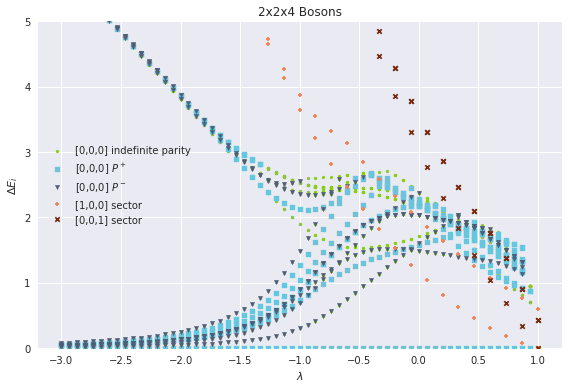

In [95]:
# Choose the dataset.
param = {
    'L' : [2,2,4],
    'gp' : 'bosons',
    'ws' : [0,0,0]
}
res_000 = EDResult(param, data_dir)
res_000.compute_gap()
df = res_000.get_eigenvalues()

# Select only the lowest states.
n_states = 25
sub = df[df['N']<n_states]


dependency = 'lambda'
observable = 'delta_e'
with plt.style.context('seaborn'):
    fig, bx = plt.subplots()
#     fig.set_size_inches(12, 6)
    
    # All points.
    bx.scatter(sub[dependency], sub[observable], marker='.', color='#8AC926', alpha=1, zorder=1, s=35, label='[0,0,0] indefinite parity')
    
    # Highlight some.
    sets = [
        (
            {'parity': 1, 'unity': 1}, 
            {"color":"#68C5DB", 'marker':'s', 'label':'[0,0,0] $P^+$', 's':25}
        ),        
        (
            {'parity': -1}, 
            {"color":"#4F5D75", 'marker':'v', 'label':'[0,0,0] $P^-$', 's':20}
        )
    ]
    for cond, style in sets:
        red = _select_close(cond, sub)
        bx.scatter(red[dependency], red[observable], **style)
        
    # ---
    # Other winding sectors.
    
    n_ws_states = 10
    ws_sets = {
        (1,0,0) : {'marker':'+', 'color':'#EF8354', 's':20},
        (0,0,1) : {'marker':'x', 'color':'#78290F', 's':20}
    }
    for ws, ws_style in ws_sets.items():
        param.update({'ws': ws})
        res_winding = EDResult(param, data_dir)

        # Get the gap.
        res_winding.compute_gap(gs=res_000.get_gs())

        # Get the lowest states.
        df = res_winding.get_eigenvalues()
        sub = df[df['N']<n_ws_states]

        bx.scatter(sub[dependency], sub[observable], **ws_style, label='[{:d},{:d},{:d}] sector'.format(*param['ws']))
        
    # ---
        
    bx.set_xlabel('$\\lambda$')
    bx.set_ylabel('$\\Delta E_i$')
    bx.set_ylim(0, 5)

    bx.legend(loc='center left')
    bx.set_title('2x2x4 Bosons')
    
    fig.tight_layout()
    fig.savefig('parity_2x2x4.png')